# Data Analysis - (Social network and property computation)
### Enrico Gavagnin

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import py_fort_myrmidon as fm
import datetime
import networkx as nx
import networkx.algorithms.community as nxc
import statistics
import scipy.stats as stats
import os
from datetime import datetime, date, timedelta
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Set working directory and open list of myrmidon files
working_dir = '/media/eg15396/EG_DATA-7/NTM/'
myrm_list = sorted([ s for s in os.listdir(working_dir) if s[15:17] == '.m'])

## Home-range communities heatmap plotting

In [3]:
# Heatmap stack calculator

def compute_HM_stack(exp, start, end):
    
    # Number of ants
    N_ants = len(exp.Ants)    
    
    # Number of 2D bins
    bins_x = range(0,8000, 50)
    bins_y = range(0,6000, 50)
    
    # initialise HM-stack (bins_y * bins_x * N_ants)
    HM_stack = [np.zeros((len(bins_y)-1,len(bins_x)-1))]*N_ants

    # Populate HM stack (loop through ants)
    for i in fm.Query.ComputeAntTrajectories(exp,start=start, end=end, maximumGap=fm.Duration(max_gap * 10**9)):
        HM_stack[i.Ant - 1] = HM_stack[i.Ant - 1] + np.histogram2d(i.Positions[:,2], 
                                                                   i.Positions[:,1], 
                                                                   bins=[bins_y, bins_x])[0]           
        
    return HM_stack

# Function which plot heatmaps of home-range
def PLOT_HM_partition(HM_stack, partition, fld_path, file_name):
    
    # Read number of communities
    n_partition = len(partition)
    
    # Read list of antIDs (needed for best partitions which don't use all the network)
    ant_list = list(frozenset().union(*list(partition)))
    
    # Initiate heatmap
    HM_part = {p: np.zeros(np.shape(HM_stack[0])) for p in range(n_partition)}
    
    # build background (by stacking the home-ranges of all the ants) 
    background = np.zeros((np.shape(HM_stack[0])[0], np.shape(HM_stack[0])[1], 3))
    for a in ant_list:
        for c in range(3):
            background[:, :, c] += HM_stack[a]
    for c in range(3):
        background[:, :, c][background[:, :, c]>0] = 1
        
        
    # Create figure with as many subplots as number of communitites
    fig, axs = plt.subplots(int(np.ceil(n_partition / 3)), 3, figsize=(15, 10))
    c = list(sns.color_palette()) + list(sns.color_palette("Set2"))

    # Loop through communitites
    for part_idx in range(n_partition):
        
        if n_partition >= 4:
            axs[part_idx // 3, part_idx % 3].imshow(background, interpolation='gaussian')
        else:
            axs[part_idx].imshow(background, interpolation='gaussian')

        # Stack the home-ranges of all the ants in partition part_idx
        part_size = 0
        for ant in ant_list:
            if ant in partition[part_idx]:
                part_size += 1
                HM_part[part_idx] += HM_stack[ant] 
   
        # Inititalise RGB map
        RGB = np.zeros((np.shape(HM_stack[0])[0], np.shape(HM_stack[0])[1], 4))
        
        # Visual adjustment
        mono_scale = HM_part[part_idx]
        mono_scale = mono_scale / np.nanpercentile(HM_part[part_idx], 98)
        mono_scale[mono_scale>1] = 1

        for rgb_idx in range(3): 
            RGB[:, :, rgb_idx] = c[part_idx][rgb_idx] 
        RGB[:, :, 3] = mono_scale

        # Plotting heatmap
        if n_partition >= 4:
            axs[part_idx // 3, part_idx % 3].imshow(RGB, interpolation='hamming') 
            axs[part_idx // 3, part_idx % 3].set_title('Community ' + str(part_idx+1) + ' - size: ' + str(part_size))
        else:
            axs[part_idx].imshow(RGB, interpolation='hamming') 
            axs[part_idx].set_title('Community ' + str(part_idx+1) + ' - size: ' + str(part_size))

    # remove axis 
    for idx_ax in range(int(np.ceil(n_partition / 3)) * 3):                
        if n_partition >= 4:
            axs[idx_ax // 3, idx_ax % 3].axis('off')
        else:
            axs[idx_ax].axis('off')
        
    plt.suptitle(file_name, fontweight="bold")
    plt.tight_layout()
    
    # Save figure
    plt.savefig(fld_path + file_name + '.png', facecolor='white', transparent=False)
    plt.close()

## Property calculator

In [4]:
def G_prop(G, exp, start, end, time_win, max_gap, name, var, nest_focus, PLOT_HM_check = False):
    
    # This function receive as input a social network and other parameters and return 
    # a dictionary with all the transmission properties computed
    # 
    # AS an option, it can call the function to plot the home-range heatmaps of the communtited detected
    
    
    # Compute connencted components
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)

    # Compute Largest Component
    GC = G.subgraph(Gcc[0])
    
    # ------------------------------------------------------------------------------ 
    # Best partition (Greedy Method)

    # Resolution parameter (see Greedy method documentation)
    res = 1
    
    if var != None:
        
        # Set fixed number of partition to 3
        fixed_p = 3
        
        # Read number of communities from file
        mode_p = mode_communities_dic[var['link_type']][name[11:14]][time_win]
    
    else: # trivial case for inititation of dataframe call
        fixed_p = 1
        mode_p = 1
    
    # Best partition (All network, unsupervised number of communities)
    best_partition = nxc.greedy_modularity_communities(G, weight='weight', resolution=res)
    
    # Best partition (Largest connected component only,  unsupervised number of communities)
    best_partition_CC = nxc.greedy_modularity_communities(GC, weight='weight', resolution=res)
   
    # Best partition (Largest connected component only,unspecified number of communities and 
    # with different resolution value)
    best_partition_CC_res_09 = nxc.greedy_modularity_communities(GC, weight='weight', resolution=0.9)
        
    # Best partition (Largest connected component with imposed number mode_p of communties)
    best_partition_CC_mode_p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=mode_p, best_n=mode_p, resolution=res)
    
    # Best partition (Largest connected component with imposed number 3 of communties)
    best_partition_CC_3p = nxc.greedy_modularity_communities(GC, weight='weight', cutoff=fixed_p, best_n=fixed_p, resolution=res)
        
    # ------------------------------------------------------------------------------ 
    
    # Plot heatmaps of home-ranges of communities (optional)
    if PLOT_HM_check:
        
        # Save HM_partition unsupervised
        directory = 'plots/HM_partition/unsup_mod/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC, 
                          directory + '/', 
                          name[7:15] + attributes)
        
        # Save HM_partition 3 communities
        directory = 'plots/HM_partition/sup_mod3p/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC_3p, 
                          directory + '/', 
                          name[7:15] + attributes)
        
        # Save HM_partition mode_p parition
        directory = 'plots/HM_partition/sup_modmp/' + myrm_file[7:10]
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        attributes = '_' + var['link_type'] + '_' + str(time_win / 3600) + 'h_' + str(var['h'])
        PLOT_HM_partition(compute_HM_stack(exp, start, end), 
                          best_partition_CC_mode_p, 
                          directory + '/', 
                          name[7:15] + attributes)
        
    # Return dictionary with all computed properties
    
    return {# replicate number
            'rep': int(name[8:10]),
            # experiment name
            'exp': name[11:15],
            # Start time
            'start': fm.Time.ToDateTime(start),
            # time aggregation window length (s)
            'time_win': time_win, 
            # focus on nest only (Boolean)
            'nest_focus': nest_focus,
            # maximum gap
            'max_gap': max_gap,
            # number of ants in the largest component
            'GC': GC.number_of_nodes(),
            # total number of ants
            'ants': G.number_of_nodes(),
            # size of communitites in the unsupervised community detection (largest connected component)
            'cMOD_communities': [len(best_partition_CC[i]) for i in range(len(best_partition_CC))],
            # size of communitites in the supervised community detection with mod_3 communtites (largest connected component)
            'cmpMOD_communities': [len(best_partition_CC_mode_p[i]) for i in range(len(best_partition_CC_mode_p))],
            # size of communitites in the supervised community detection with 3 communtites (largest connected component)
            'c3pMOD_communities': [len(best_partition_CC_3p[i]) for i in range(len(best_partition_CC_3p))],
            # size of communitites in the unsupervised community detection with different resolution (largest connected component)
            'cMODres09_communities': [len(best_partition_CC_res_09[i]) for i in range(len(best_partition_CC_res_09))],
            # Modularity coefficient for the unsupervised community detection (all network)
            'MOD': nxc.modularity(G, best_partition),
            # Modularity coefficient for the unsupervised community detection (largest connected component)
            'cMOD': nxc.modularity(GC, best_partition_CC),
            # Modularity coefficient for the supervised community detection with 3 communtites (largest connected component)
            'c3pMOD': nxc.modularity(GC, best_partition_CC_3p),
            # Modularity coefficient for the supervised community detection with mod_p communtites (largest connected component)
            'cmpMOD': nxc.modularity(GC, best_partition_CC_mode_p),
            # Density 
            'DEN': nx.density(G), 
            # Diameter (unweighted)
            'DIA': nx.diameter(GC),
            # Diameter (weighted)
            'wDIA': nx.diameter(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            # Radius (unweighted)
            'RAD': nx.radius(GC),
            # Radius (weighted)
            'wRAD': nx.radius(GC, e=nx.eccentricity(GC, sp=dict(nx.shortest_path_length(GC,weight='inv_weight')))),
            # Degree heterogeneity (All network)
            'DEH': np.std([G.degree(n) for n in G.nodes()]),
            # Degree heterogeneity (Largest connected component)
            'cDEH': np.std([GC.degree(n) for n in GC.nodes()]),
            # Weighted degree heterogeneity - ie Strength heterogeneity (All network)
            'wDEH': np.std(nx.adjacency_matrix(G).sum(axis=0)), 
            # Weighted degree heterogeneity - ie Strength heterogeneity (Largest connected component)
            'cwDEH': np.std(nx.adjacency_matrix(GC).sum(axis=0)),
            # Clustering (weighted)
            'CLS': np.mean([c for c in nx.clustering(G, weight='weight').values()]) 
            }

# initialise data-frame with properties
prop_df = pd.DataFrame(columns=G_prop(nx.star_graph(5),[],fm.Time.Now(),[],1,1,myrm_list[0],var=None, nest_focus=True).keys())

## Graph calculator

In [5]:
# Function to compute the cumulative interaction function
def compute_G(exp, start, end, min_cum_duration, frm_rate, link_type, nest_focus):
    
    # This function return the time-aggregated social network according to all 
    # the parameters received as input
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))

    # Dictionary to convert timestamp of frame into corresponding frame number starting from 1 (with frame#1 at 'start' time)
    TimeToFrame = {fm.Time.ToTimestamp(frm[0].FrameTime): i + 1 
                   for i, frm in enumerate(fm.Query.CollideFrames(exp,start=start,end=end))}

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp, start=start, end=end, maximumGap=fm.Duration(max_gap*10**9),
                                             reportFullTrajectories= False)[1]:
        
        # Focus on Nest zone (id=1)
        if nest_focus & ~(1 in i.Trajectories[1].Zones):
            continue

        if link_type == 'length_inter':
        # WEIGHTS: cumulative interaction time (s)
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] += (TimeToFrame[fm.Time.ToTimestamp(i.End)] - 
                                                TimeToFrame[fm.Time.ToTimestamp(i.Start)]) * 1 / frm_rate
        
        elif link_type == '#inter':
        # WEIGHTS: number of interactions
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] += 1
            
        else:
            raise TypeError('"link_type" not valid')


    # interaction filtering (remove weak connections)
    adj_mat[adj_mat <  min_cum_duration] = 0

    # Build network 
    G = nx.Graph(adj_mat)

    # store inverse of weights (for shortest path measures)
    nx.set_edge_attributes(G, {(i,j): 1 / adj_mat[j, i] if adj_mat[j, i] > 0 else 0 
                               for i in range(len(adj_mat)) for j in range(i)}, 'inv_weight')
    return G


## Main script

This script loops through all the myrmidon files. For each replicate it construct the social network, compute all the network properties and save them in a dataframe called prop_df.

In [6]:
## ========= PARAMETERS========= 
# Frame rate
frm_rate = 6

# max gap for different interactions (s)
max_gap = 10

# minimum interaction weight (OPTIONAL, set=0 if not wanted)
min_cum_duration = 0 

# Read file with modes of communities number computed      
with open('data/mode_communities.pkl', 'rb') as f:
    mode_communities_dic = pickle.load(f)

# ========= Edges weights type ==========
# Decide what type of weight for the edges of the social network 
#     'length_inter': cumulative interaction time (s))    
#     '#inter': number of interactions    

link_type = 'length_inter'

# ========= Nest focus zone ==========
# Set weather to only consider interactions happening within the nest zone
#     'True': Nest only
#     'False': All interactions considered
nest_focus = True

# Plot home-range heatmaps of communities (slow)
PLOT_HM = False

data_saving_name = 'data/polish_data_test' + link_type + '_NF_F.pkl'

# initialise data-frame with properties
prop_df = pd.DataFrame(columns=G_prop(nx.star_graph(5), [], fm.Time.Now(),
                                      [], 1, 1, myrm_list[0], var=None, 
                                      nest_focus=True).keys())

# Loop through the myrmidon files
for myrm_file in myrm_list[20:21]:

    # Skip replicate 41 (major escape), and all the replicates of the first 3 blocs (different tag orientation)
    if int(myrm_file[8:10])==41 or int(myrm_file[8:10])<13: 
        continue

    print(myrm_file)

    # Open experiment file
    exp = fm.Experiment.Open(working_dir + myrm_file)

    
    # Read the start date of the time window to be considered for the analysis
    # (ie the day before the experiment has been terminated)
    start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                 timedelta(days = -1)).strftime("%Y-%m-%d")

    # ======== Total cumulative time window ========
    # Define the start/end of the entire time window to be considered to the analysis
    # ie from 9:00am of start_date to 9:00am of the following day
    
    start = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
    end = start.Add(fm.Duration(60 * 60 * 24 * 10**9))
    
    # ======== Loop different time aggregated windows ========
    # Test different lengths of time aggregation (h)
    for time_win_h in [1]:#, 2, 3, 4, 6]:

        # Loop through non-overlapping time windows of the given length
        for tw in range(0,25 - time_win_h, time_win_h):
            
            print('Time_win:' + str (time_win_h) + 'h - time_slot: #' + str(tw + 1))
            
            # Compute start/end of the time window
            s = start.Add(fm.Duration(tw * 60**2 * 10**9))
            e = start.Add(fm.Duration((tw + time_win_h) * 60**2 * 10**9))

            # Compute network
            G = compute_G(exp, s, e, min_cum_duration, frm_rate, link_type, nest_focus=nest_focus)

            # variables dict
            var = {'link_type': link_type, 'time_win': time_win_h * 60**2, 'h': tw}

            # Compute network properties and save them in prop_df
            prop_df = prop_df.append(G_prop(G, 
                                            exp, 
                                            s, e, 
                                            time_win_h * 60**2, 
                                            max_gap, 
                                            myrm_file, var = var, 
                                            nest_focus=nest_focus, 
                                            PLOT_HM_check = PLOT_HM), ignore_index=True)

# Save dataframe
a_file = open(data_saving_name, "wb")
pickle.dump(prop_df, a_file)
a_file.close()

prop_df

EG_NTM_s13_DEHa.myrmidon
Time_win:1h - time_slot: #1
Time_win:1h - time_slot: #2
Time_win:1h - time_slot: #3
Time_win:1h - time_slot: #4
Time_win:1h - time_slot: #5
Time_win:1h - time_slot: #6
Time_win:1h - time_slot: #7
Time_win:1h - time_slot: #8
Time_win:1h - time_slot: #9
Time_win:1h - time_slot: #10
Time_win:1h - time_slot: #11
Time_win:1h - time_slot: #12
Time_win:1h - time_slot: #13
Time_win:1h - time_slot: #14
Time_win:1h - time_slot: #15
Time_win:1h - time_slot: #16
Time_win:1h - time_slot: #17
Time_win:1h - time_slot: #18
Time_win:1h - time_slot: #19
Time_win:1h - time_slot: #20
Time_win:1h - time_slot: #21
Time_win:1h - time_slot: #22
Time_win:1h - time_slot: #23
Time_win:1h - time_slot: #24


,rep,exp,start,time_win,nest_focus,max_gap,GC,ants,cMOD_communities,cmpMOD_communities,...,DEN,DIA,wDIA,RAD,wRAD,DEH,cDEH,wDEH,cwDEH,CLS
0,13,DEHa,2021-09-12 09:00:00,3600,True,10,151,177,"[41, 27, 21, 20, 20, 11, 11]","[41, 27, 21, 20, 20, 11, 11]",...,0.269902,3,0.845879,2,0.461538,33.888839,29.845601,1732.008241,1630.859821,0.003631
1,13,DEHa,2021-09-12 10:00:00,3600,True,10,144,177,"[34, 31, 24, 19, 17, 10, 9]","[34, 31, 24, 19, 17, 10, 9]",...,0.239214,4,0.575377,2,0.4,31.552142,26.940775,1999.218274,1944.972564,0.003163
2,13,DEHa,2021-09-12 11:00:00,3600,True,10,147,177,"[36, 25, 24, 17, 15, 11, 10, 9]","[36, 25, 25, 24, 17, 11, 9]",...,0.302067,4,3.886259,2,3.0,36.854597,30.674501,1470.493684,1337.911465,0.007119
3,13,DEHa,2021-09-12 12:00:00,3600,True,10,135,177,"[43, 24, 14, 13, 11, 11, 8, 8, 3]","[43, 24, 16, 16, 14, 11, 11]",...,0.195686,4,0.880484,2,0.5,28.633435,24.312736,1428.001667,1392.096855,0.004084
4,13,DEHa,2021-09-12 13:00:00,3600,True,10,137,177,"[41, 27, 19, 16, 15, 12, 7]","[41, 27, 19, 16, 15, 12, 7]",...,0.279404,3,4.02687,2,3.0,35.837169,27.33305,1396.815033,1264.837355,0.006493
5,13,DEHa,2021-09-12 14:00:00,3600,True,10,139,177,"[36, 28, 16, 14, 11, 11, 10, 8, 5]","[47, 28, 21, 14, 11, 10, 8]",...,0.194787,5,5.49039,3,3.0,29.99754,27.1425,1336.000071,1254.129993,0.00616
6,13,DEHa,2021-09-12 15:00:00,3600,True,10,135,177,"[22, 22, 21, 18, 16, 14, 12, 10]","[43, 22, 18, 16, 14, 12, 10]",...,0.207499,4,3.020573,2,2.0,30.641741,26.210841,1159.674308,1061.206805,0.004978
7,13,DEHa,2021-09-12 16:00:00,3600,True,10,135,177,"[41, 37, 31, 15, 6, 5]","[41, 36, 31, 15, 6, 5, 1]",...,0.227401,4,12.0364,2,6.018596,32.528641,27.091021,1415.114694,1349.361517,0.004095
8,13,DEHa,2021-09-12 17:00:00,3600,True,10,138,177,"[26, 24, 23, 22, 13, 13, 9, 8]","[45, 26, 24, 13, 13, 9, 8]",...,0.22509,4,1.916551,2,1.5,31.754343,26.915205,1448.568982,1382.666932,0.004281
9,13,DEHa,2021-09-12 18:00:00,3600,True,10,147,177,"[49, 30, 26, 16, 13, 9, 4]","[49, 30, 26, 16, 13, 9, 4]",...,0.268747,4,1.822202,2,1.2,34.541151,29.779538,1422.302475,1367.194352,0.004487


## Computing mode of communitites Greedy
This script compute the mode of the number of communities abtained with unsupervised greedy algorithm and save the result in a file called mode_communities.pkl

In [34]:
# Mode of communities number with greedy algorithm 

# ========== FILTERING ============
reps_discarded = [20,41]
mode_communities_dic = {}

for data_file_name in ['data/prop_data_1_2_3_4_6length_inter_NF_F.pkl']:

    df = pd.read_pickle(data_file_name)
    
    if '_#inter_' in data_file_name:
        link_type = '#inter'
    elif '_length_inter_'in data_file_name:
        link_type = 'length_inter'
    
    mode_communities_dic[link_type] = {}

    for exp in ['MOD', 'DIA', 'DEN', 'DEH']:
        mode_communities_dic[link_type][exp] = {}
        
        for time_win in [1, 2, 3, 4, 6]:
            
            df_filt = df.loc[(df.time_win==3600 * time_win) &  
                            (df.exp.isin([exp+'a',exp+'b'])) & 
                            (~df.rep.isin(reps_discarded))]
            
            mode_communities_dic[link_type][exp][time_win * 3600] = stats.mode([len(com) for com in df_filt.cMOD_communities]).mode[0]
    

a_file = open('data/mode_communities.pkl', "wb")
pickle.dump(mode_communities_dic, a_file)

## Connectivity Analysis

This script contains an auxiliary function which compute the size of the largest connected component as a funciton of the size time window of aggregation (Percolation analysis) 

NOT WELL DOCUMENTED

In [ ]:
# Time vs Connectivity

def compute_Gcc(exp, start, end):
    
    # Number of ants
    N_ants = len(exp.Ants)    

    # initialise adj-matrix
    adj_mat = np.zeros((N_ants, N_ants))
    
    Gcc = [[sorted(nx.connected_components(nx.Graph(adj_mat)), key=len, reverse=True)],
           [0]]

    # Populate network
    for i in fm.Query.ComputeAntInteractions(exp,start=start,end=end,maximumGap=fm.Duration(max_gap*10**9),
                                            reportFullTrajectories= False)[1]:
        # Focus on Nest zone (id=1)
        if (1 in i.Trajectories[1].Zones) & (adj_mat[i.IDs[0]-1, i.IDs[1]-1] == 0):
            
            adj_mat[i.IDs[0]-1, i.IDs[1]-1] = 1           
         
            if i.Start.After(start.Add(fm.Duration((Gcc[1][-1] + 1) * 10**9))):
    
                Gcc[0].append(sorted(nx.connected_components(nx.Graph(adj_mat)), key=len, reverse=True))
                Gcc[1].append(Gcc[1][-1] + 1)
                    
    # network build
    return   Gcc

## ============= LOOP =============== 

Gcc_df = pd.DataFrame(columns=['rep', 'exp', 'Gcc'])
max_gap = 10
for myrm_file in myrm_list[20:]:

    if int(myrm_file[8:10])==41: 
        continue

    print(myrm_file)

    # Open experiment file
    exp = fm.Experiment.Open(working_dir + myrm_file)

    ## ------ Time window ------ 
    start_date = (fm.Time.ToDateTime(fm.Query.GetDataInformations(exp).End) +
                 timedelta(days = -1)).strftime("%Y-%m-%d")

    start_time = fm.Time(datetime.fromisoformat(start_date + 'T09:00:00'))  
    Gcc = compute_Gcc(exp,start_time,start_time.Add(fm.Duration(12 * 60 * 60 * 10**9)))
    Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)
    
# Save
a_file = open("data/Gcc_NEST.pkl", "wb")
pickle.dump(Gcc_df, a_file)
a_file.close()


EG_NTM_s13_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s13_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s14_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s14_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s15_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s15_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s16_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s16_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s17_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s17_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s18_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s18_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s19_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s19_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s20_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s20_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s21_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s21_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s22_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s22_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s23_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s23_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s24_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s24_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s25_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s25_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s26_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s26_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s27_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s27_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s28_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s28_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s29_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s29_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s30_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s30_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s31_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s31_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s32_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s32_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s33_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s33_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s34_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s34_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s35_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s35_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s36_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s36_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s37_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s37_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s38_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s38_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s39_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s39_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s40_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s40_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s42_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s42_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s43_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s43_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s44_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s44_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s45_DENa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s45_DENb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s46_DIAa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s46_DIAb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s47_DEHa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s47_DEHb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s48_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s48_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s49_MODa.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s49_MODb.myrmidon


/tmp/ipykernel_23904/3396144109.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Gcc_df = Gcc_df.append({'rep': int(myrm_file[8:10]), 'exp': myrm_file[11:15], 'Gcc': Gcc}, ignore_index=True)


EG_NTM_s50_DIAa.myrmidon


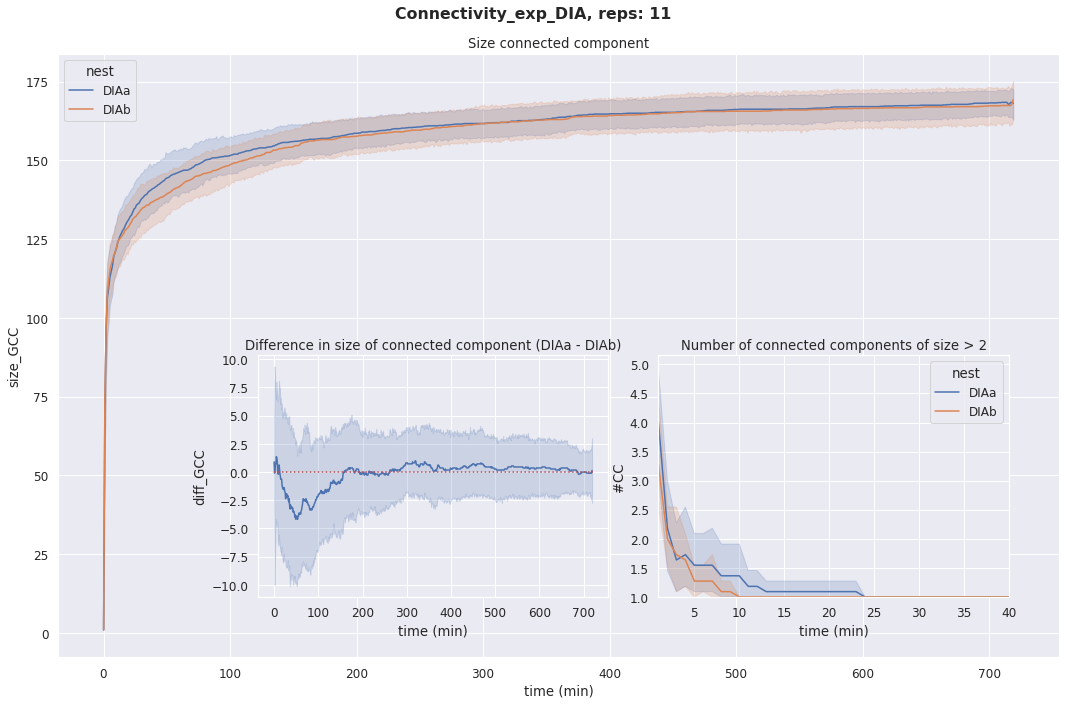

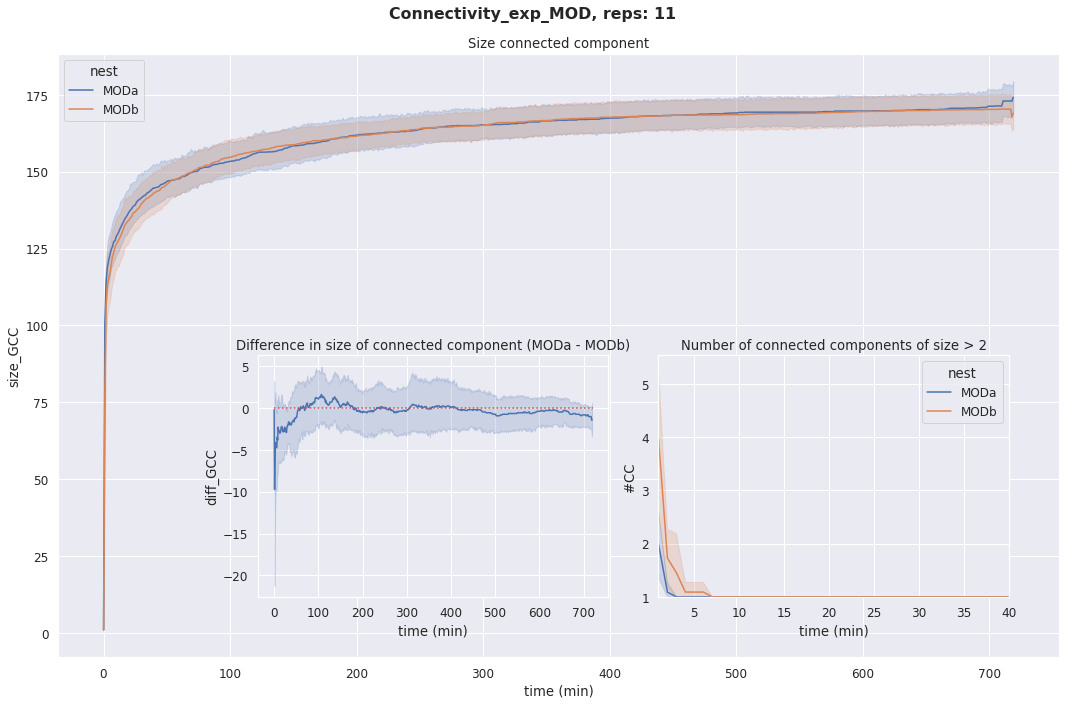

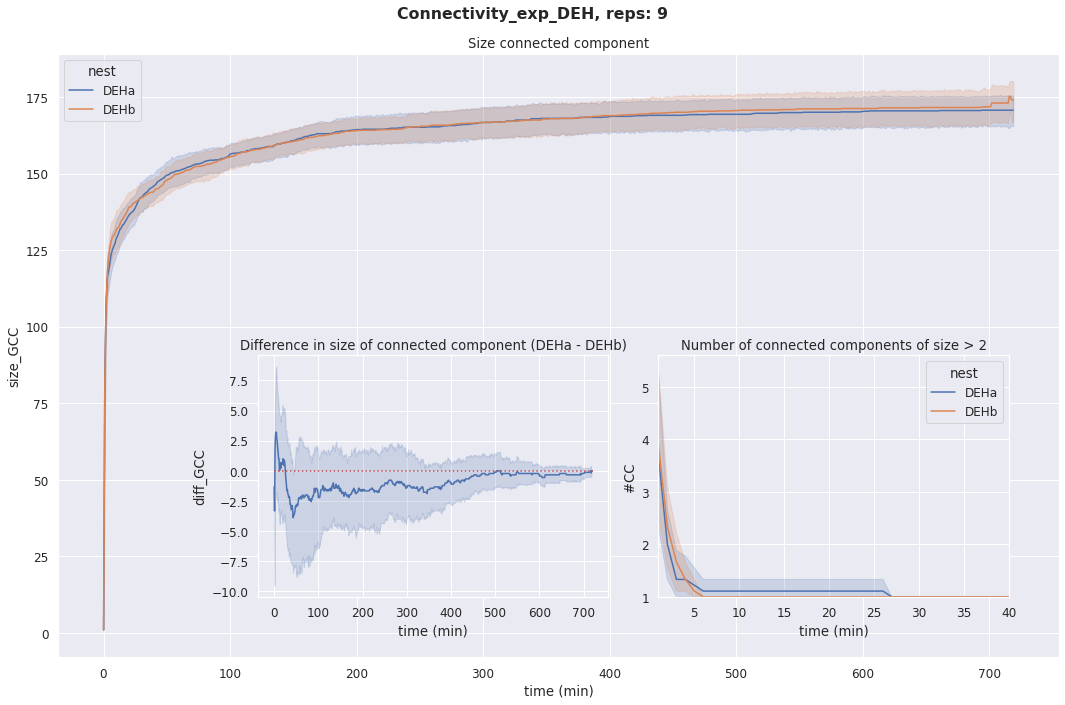

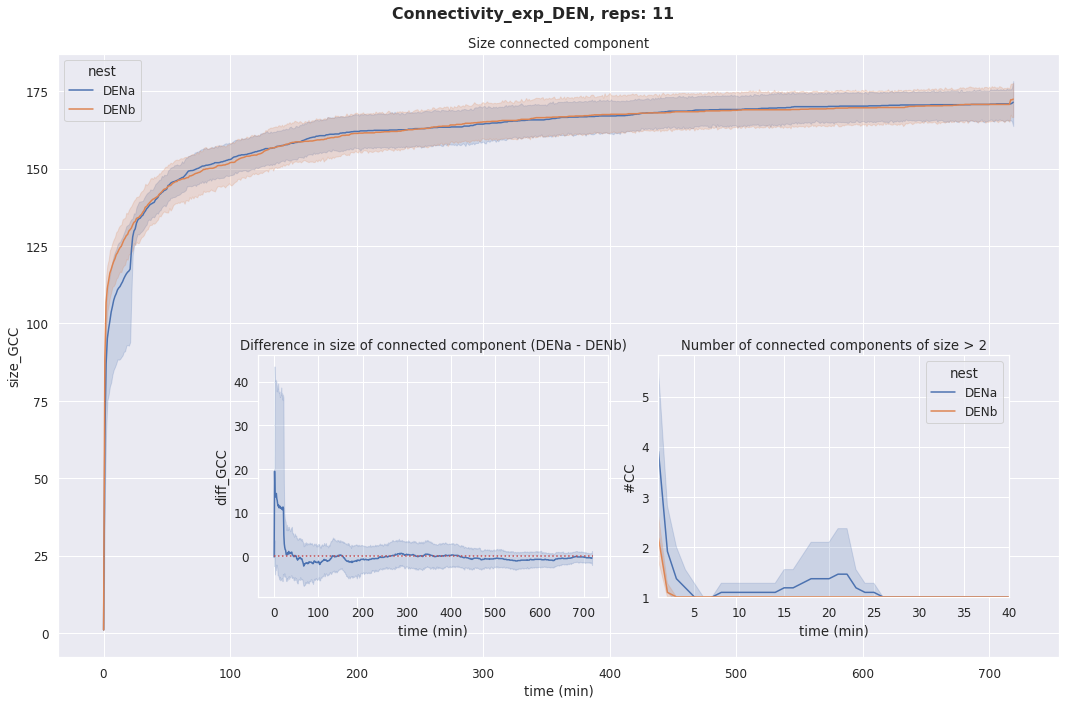

In [37]:

plot_fld_path = 'plots/Connectivity/'


for exp in ['DIA', 'MOD', 'DEH', 'DEN']:
    
    # Reading dataframe of connectivity
    Gcc_df = pd.read_pickle('data/Gcc_NEST.pkl')

    
    #Filter for the experiement of interest
    Gcc_df = Gcc_df[Gcc_df.rep != 20]
    Gcc_df = Gcc_df[[e[0:3] == exp for e in Gcc_df.exp]]
    Gcc_df.sort_values(['rep','exp'])
    connect_df = pd.DataFrame(columns=['rep', 'nest', 'time (min)', 'size_GCC', '#CC'])

    # treshold minimal partition size
    tresh_part = 2

    # Reformatting dataframe
    for row in range(len(Gcc_df)):
        df_aux = pd.DataFrame({'rep': [Gcc_df.rep.iloc[row]] * len(Gcc_df.Gcc.iloc[row][0]),
                              'nest': [Gcc_df.exp.iloc[row]] * len(Gcc_df.Gcc.iloc[row][0]),
                              'time (min)': Gcc_df.Gcc.iloc[row][1],
                              'size_GCC': [len(cc[0]) for cc in Gcc_df.Gcc.iloc[row][0]],
                              '#CC': [sum([len(p) > tresh_part for p in cc]) for cc in Gcc_df.Gcc.iloc[row][0]]})
        connect_df = pd.concat([connect_df, df_aux], ignore_index=True)

    # Plotting    
    sns.set(font_scale = 1.1)
    fig, axs = plt.subplots(1, 1, figsize=(15,10))
    title = 'Connectivity_exp_' + exp + ', reps: ' + str(int(len(Gcc_df)/2)) 
    supt = plt.suptitle(title, fontweight="bold")
    # Plot 1 (size GCC)
    sns.lineplot(data=connect_df, x="time (min)", y="size_GCC", hue="nest", ax=axs)
    axs.set_title('Size connected component')
    plt.tight_layout()
    axs_i_r = axs.inset_axes([0.6,0.1,0.35,0.4])

    # Plot 1 (number CC)
    sns.lineplot(data=connect_df, x="time (min)", y="#CC", hue="nest", ax=axs_i_r)
    axs_i_r.set_title('Number of connected components of size > ' + str(tresh_part))
    axs_i_r.set_xlim([1,40])
    axs_i_r.set_ylim(bottom=1)
    plt.tight_layout()

    # ====================================
    # Difference in size of GCC
    diff_connect_df = pd.DataFrame(columns=['rep', 'time (min)', 'diff_GCC'])

    def diff_list_GCC(A, B):
        A_len = [len(a) for a in A]
        B_len = [len(b) for b in B]
        return [A_len[i] - B_len[i] for i in range(min(len(A), len(B)))]

    # Reformatting dataframe
    for row in range(0, len(Gcc_df) -1, 2):
        diff_GCC = diff_list_GCC(Gcc_df.Gcc.iloc[row][0], Gcc_df.Gcc.iloc[row + 1][0])
        df_aux = pd.DataFrame({'rep': [Gcc_df.rep.iloc[row]] * len(diff_GCC),
                              'time (min)': range(len(diff_GCC)),
                              'diff_GCC': diff_GCC})
        diff_connect_df = pd.concat([diff_connect_df, df_aux], ignore_index=True)

    # Plotting    
    # Plot 3 (diff size GCC)
    axs_i_l = axs.inset_axes([0.2,0.1,0.35,0.4])
    sns.lineplot(data=diff_connect_df, x="time (min)", y="diff_GCC", ax=axs_i_l)
    axs_i_l.plot([0, 720], [0, 0], ':r')
    axs_i_l.set_title('Difference in size of connected component (' + Gcc_df.exp.iloc[0] + ' - ' + Gcc_df.exp.iloc[1] + ')')
    plt.tight_layout()

    file_name = 'Connectivity_exp_' + exp 

    #Savefig
    plt.savefig(plot_fld_path + file_name + '.png', facecolor='white', transparent=False)

